# Prepare Imagenette dataset

The dataset is stored under `./data/imagenette2`

In [ ]:
#|export
import os
import shutil
import random
import torchvision
from torchvision.datasets.utils import download_and_extract_archive as __download_and_extract_archive
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from export import serialize_fp32

In [ ]:
#|export
data_root = 'data'
imagenette2_root = os.path.join(data_root, 'imagenette2')

In [ ]:
data_root, imagenette2_root

('data', 'data/imagenette2')

In [ ]:
#|export
def download_and_extract_archive(root=data_root):
    os.makedirs(root, exist_ok=True)
    url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz"
    __download_and_extract_archive(url, download_root=root, extract_root=root)

In [ ]:
#|export
def find_files(root:str=data_root, ext:str='jpeg') -> list[str]:
    ext = '.' + ext if len(ext) else ''
    l = [os.path.join(d, o) for d, _, files in os.walk(root) for o in files if o.lower().endswith(ext)]
    return l

In [ ]:
#|export
dls = ImageFolder(os.path.join(imagenette2_root, 'val'),
                  transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))
val_tx_root = os.path.join(imagenette2_root, 'val_transformed')

## Resize validation dataset with 224*224

In [ ]:
def resize(root=val_tx_root, dls=dls):
    subdirs = [os.path.join(root, str(l)) for l in dls.class_to_idx.values()]
    for d in subdirs:
        os.makedirs(d, exist_ok=True)

    for i, (image, label) in enumerate(dls):
        if i % 500 == 0:
            print(f"Wrote {i:>8}/{len(dls)}")

        path = os.path.join(root, str(int(label)), str(i))
        with open(path, "wb") as f:
            serialize_fp32(f, image)
    print("Done")

In [ ]:
download_and_extract_archive()
assert len(find_files())==13394 # no. of the original JPEG files from imagenette2 validationset

Using downloaded and verified file: data/imagenette2.tgz
Extracting data/imagenette2.tgz to data


In [ ]:
original = find_files(os.path.join(imagenette2_root, 'val'))
modified = find_files(val_tx_root, ext='')
if len(original)!=len(modified):
    resize()
assert len(original)==len(modified), "faile to resize()?"

In [ ]:
#|export
import matplotlib.pyplot as plt
import torch
import struct

def show_image(label, number):
    path = os.path.join(val_tx_root, str(label), str(number))
    with open(path, "rb") as f:
        sizeof_float, nch, h, w = 4, 3, 224, 224
        image = torch.tensor(struct.unpack("f"*(nch*h*w), f.read(sizeof_float*nch*h*w))).view(nch,h,w)

    # imshow accepts image shape (height, width, nch)
    image_transposed = image.permute(1, 2, 0) 
    plt.imshow(image_transposed)
    print(f"Image shape (nch, h, w): {(nch, h, w)} {path}")

Image shape (nch, h, w): (3, 224, 224) data/imagenette2/val_transformed/0/0


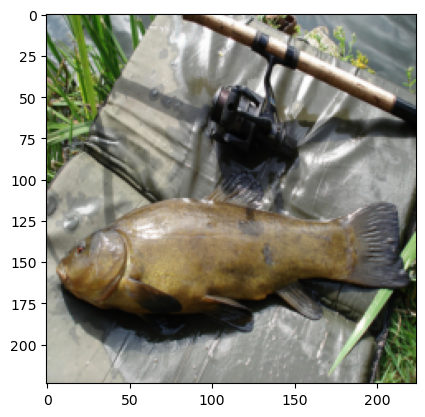

In [ ]:
show_image(0,0)

In [ ]:
#|export
def sample_files(src, dst, n=10, seed=4):
    """create directory containing the subset of `src`"""
    shutil.rmtree(dst, ignore_errors=True)
    subdirs = [o for o in os.listdir(src) if os.path.isdir(os.path.join(src, o))]
    for o in subdirs:
        files = os.listdir(os.path.join(src, o))
        random.Random(seed).shuffle(files)
        for f in files[:n]:
            os.makedirs(os.path.join(dst, o), exist_ok=True)
            shutil.copy(os.path.join(src, o, f), os.path.join(dst, o, f))

## Prepare subset from resized validation dataset

In [ ]:
src = os.path.join(imagenette2_root, 'val_transformed')
dst = os.path.join(imagenette2_root, 'val_transformed_subset')
sample_files(src, dst)

In [ ]:
import hashlib

def cmp_tree(s, d):
    def file_hash(path):
        h = hashlib.sha256()
        with open(path, "rb") as f:
            for chunk in iter(lambda: f.read(4096), b""):
                h.update(chunk)
        return h.hexdigest()
    for s, d in zip(s, d):
        if file_hash(s)!=file_hash(d):
            return False
    return True

d = find_files(dst, ext='')
s = [o.replace('val_transformed_subset', 'val_transformed') for o in d]
assert cmp_tree(s, d)==True